In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'])


In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_i = sales_i.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_i.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,50833,600282,1024825
1,2019-02-01,65670,775491,1323949
2,2019-03-01,89667,1058869,1807743
3,2019-04-01,60960,719871,1228992
4,2019-05-01,43410,512625,875173


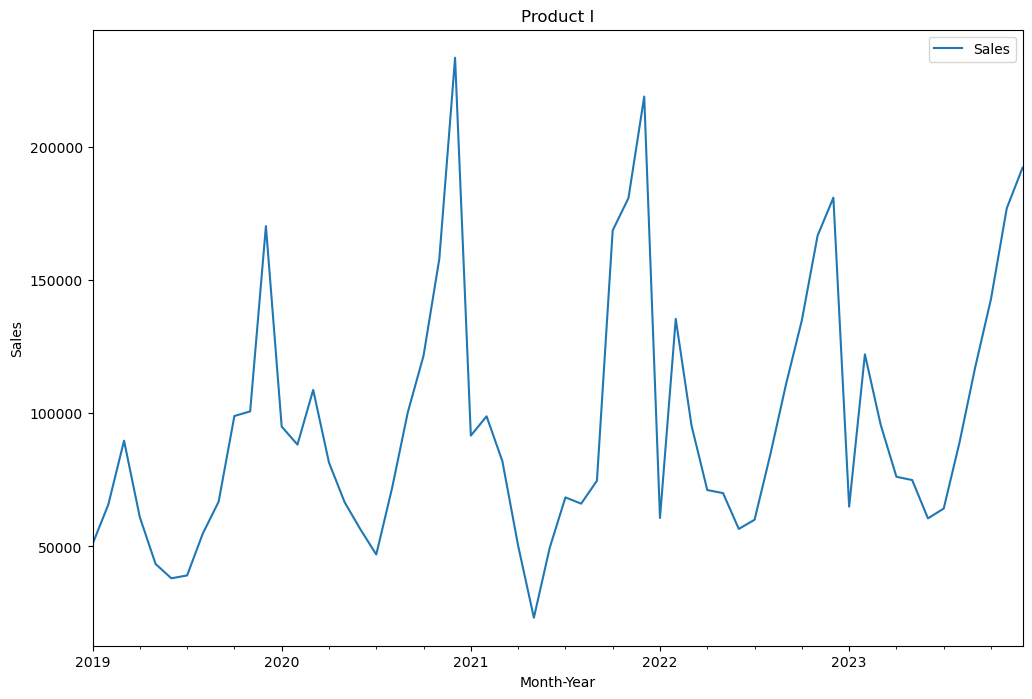

In [5]:
ax = sales_i.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product I')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_i[:57]
test=sales_i[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing
12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing
12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing
12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing
12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing
12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:52 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   16477.179319  
1   18602.690801  
2   17757.281436  
3   16244.400441  
4   18044.301619  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
67,0.5,3.00,multiplicative,13551.362340
69,0.5,5.00,multiplicative,14624.693475
71,0.5,10.00,multiplicative,15795.459346
48,0.3,0.01,additive,16005.697318
36,0.2,0.01,additive,16050.925711
...,...,...,...,...
68,0.5,5.00,additive,20697.671862
66,0.5,3.00,additive,21408.920917
61,0.5,0.01,multiplicative,21465.438035
64,0.5,1.00,additive,23104.093801


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 3.0, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=3.0, seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

13:06:04 - cmdstanpy - INFO - Chain [1] start processing
13:06:04 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_i['Market Size']
future_dates['Marketing Expense'] = sales_i['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,600282,1024825
1,2019-02-01,775491,1323949
2,2019-03-01,1058869,1807743
3,2019-04-01,719871,1228992
4,2019-05-01,512625,875173
5,2019-06-01,449010,766568
6,2019-07-01,461693,788220
7,2019-08-01,647955,1106214
8,2019-09-01,788516,1346186
9,2019-10-01,1188838,2029631


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,166605.825061,151582.582781,181565.708991
58,2023-11-01,147664.986086,132045.233979,163463.607783
59,2023-12-01,199295.868909,182546.195154,215483.944196


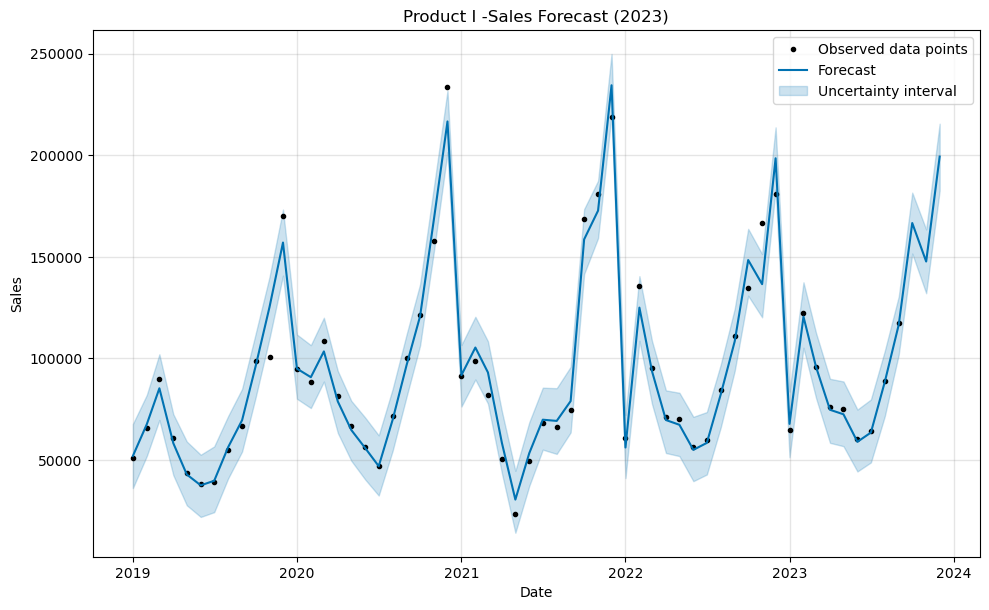

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product I -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

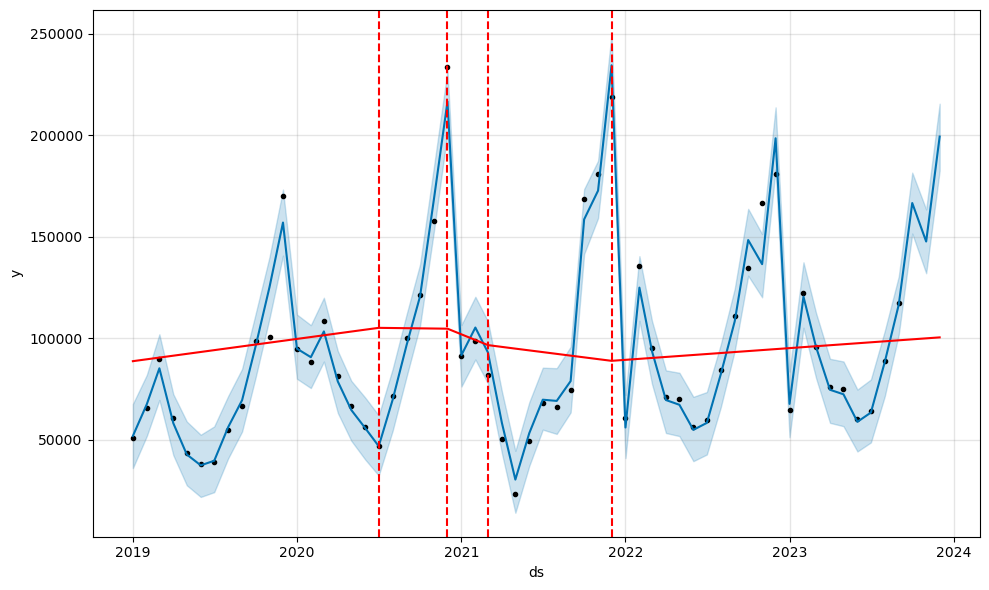

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

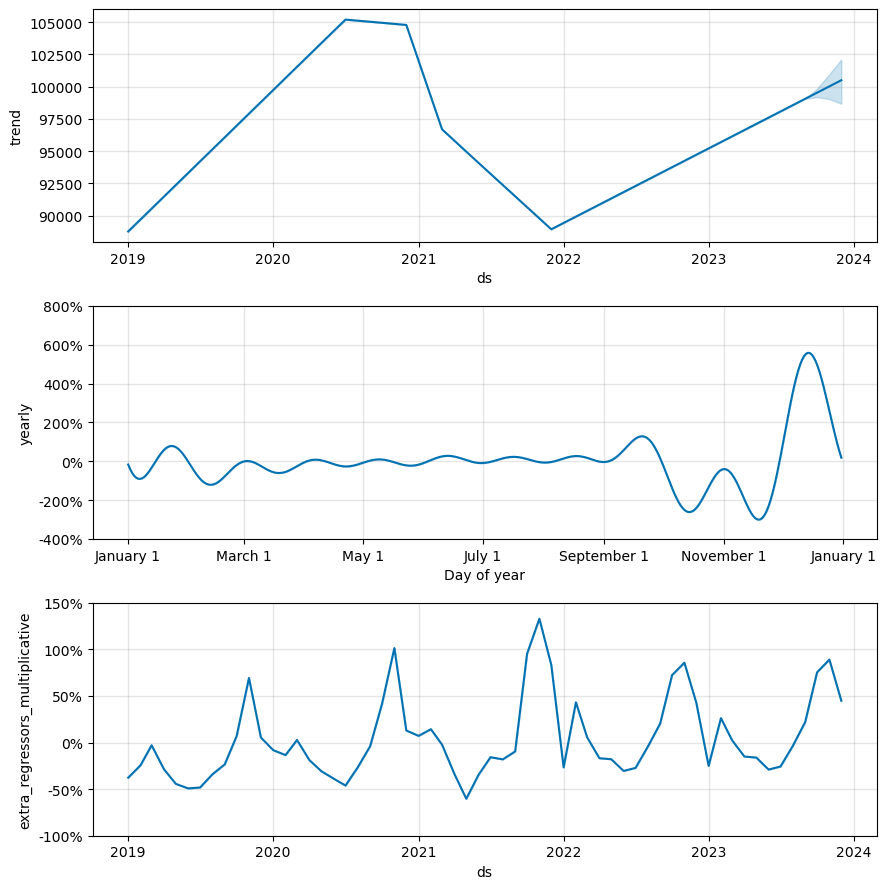

In [21]:
fig2 = model.plot_components(forecast)

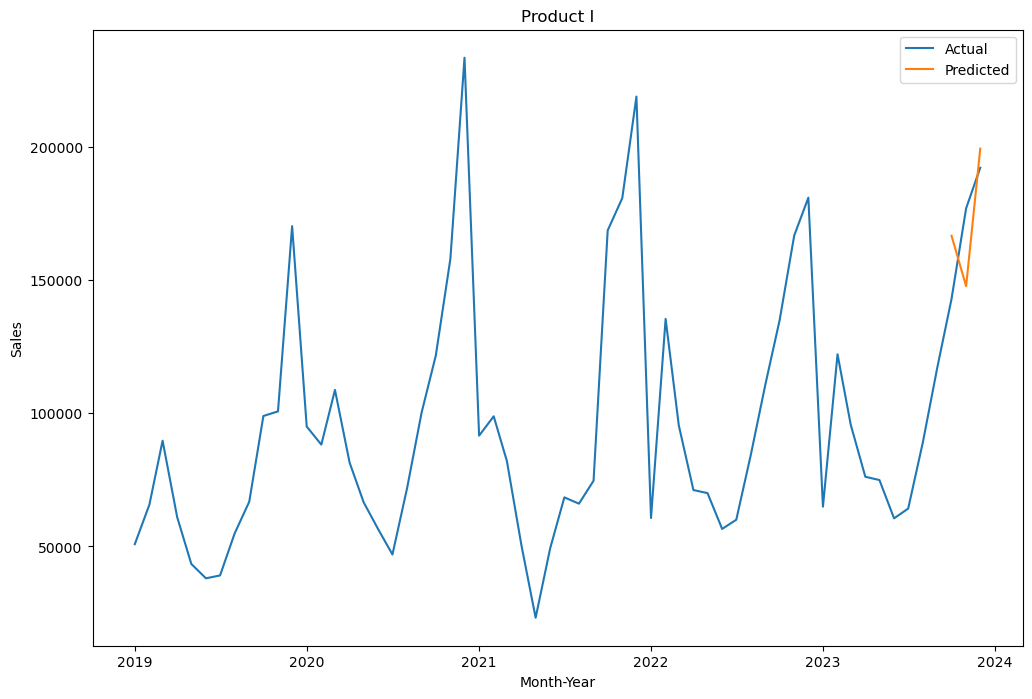

In [22]:
# Reset index of sales_b DataFrame
sales_i_reset_index = sales_i.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_i_reset_index['ds'], sales_i_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product I')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 20042.569
MAPE - FB PROPHET: 0.123
MSE - FB PROPHET: 489574032.784
RMSE - FB PROPHET: 22126.320


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,3.463787e+07,5885.395038,5350.254731,0.062477,0.050383,0.064906,0.000000
1,22 days,3.635447e+07,6029.466828,5072.020499,0.053177,0.050383,0.055363,0.333333
2,23 days,1.946550e+07,4411.972245,3785.655648,0.062133,0.077251,0.062928,0.666667
3,25 days,2.198673e+08,14827.921808,10963.006459,0.105466,0.099519,0.100186,0.833333
4,27 days,2.092003e+08,14463.759044,9459.022249,0.077365,0.035582,0.072359,1.000000
5,28 days,3.633931e+06,1906.287327,1735.080301,0.024778,0.026810,0.025090,1.000000
6,47 days,6.756617e+06,2599.349268,2371.764860,0.069262,0.035582,0.073950,0.666667
7,49 days,1.660645e+07,4075.101682,3720.946115,0.090563,0.087664,0.096494,0.333333
8,51 days,1.916216e+08,13842.744219,10806.693541,0.124004,0.127135,0.132691,0.000000
9,52 days,1.875619e+08,13695.324280,9948.148537,0.076726,0.087664,0.080982,0.333333


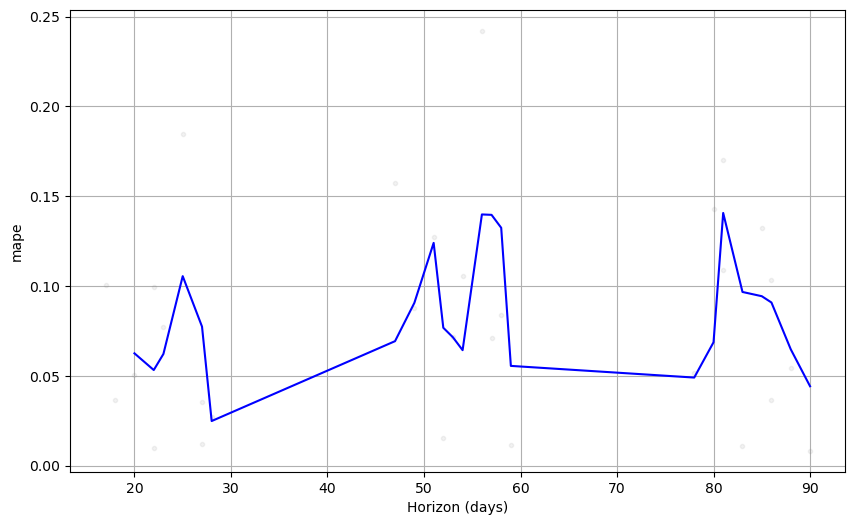

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    142882
58    176896
59    192123
Name: y, dtype: int64

In [30]:
pred

57    166605.825061
58    147664.986086
59    199295.868909
Name: yhat, dtype: float64